In [1]:
import numpy as np
import h5py as h5
import logging
from collections import namedtuple
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow import random_normal_initializer

def _config(layer, config):
    base_config = super(layer.__class__, layer).get_config()
    conf_dict = dict(base_config.items()).copy()
    conf_dict.update(dict(config.items()))
    return conf_dict

class OffsetAndScale(keras.layers.Layer):
    """ (x + offset) * scale """

    def __init__(self, offset, scale, **kwargs):
        self.offset = offset
        self.scale = scale

        if isinstance(self.scale, dict) and self.scale['type'] == 'ndarray':
            self.scale = np.array(self.scale['value']).astype('float32')

        if isinstance(self.offset, dict) and self.offset['type'] == 'ndarray':
            self.offset = np.array(self.offset['value']).astype('float32')

        super(OffsetAndScale, self).__init__(**kwargs)

    def call(self, x):
        return (x + self.offset) * self.scale

    def get_config(self):
        return _config(self, {
            'offset': self.offset,
            'scale': self.scale
        })

In [14]:
Option = namedtuple("MyStruct", "data_input model_output structure learning_rate regularizer batch_size epochs \
                    momentum patience")
                    # folds batch_size epochs")
                    #structure learning_rate regularizer epochs")
args = Option(
    data_input='data/training.h5',
    model_output='output/tf_model',
    structure=[20, 20, 20, 20, 20],
    learning_rate=0.004,
    regularizer=1e-6,
    batch_size=60,
    epochs=20,
    #folds=10,
    momentum=0.2,
    patience=5,
)

In [3]:
logging.info(f'Loading data from {args.data_input}')

with h5.File(args.data_input, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]
    #data_x = data['input'][:5000]
    #data_y = data['target'][:5000]

    
labels = ['1particle', '2particle', '3particle']
print(data_x.shape)

(12000001, 60)


In [15]:
std = np.std(data_x, axis=0, ddof=1)
std[np.where(std == 0)] = 1
init = random_normal_initializer(seed=42)

inputs = Input((data_x.shape[1],))

h = OffsetAndScale(offset=-np.mean(data_x, axis=0), scale=1.0/std)(inputs)

for l in range(0, len(args.structure)):
    h = Dense(args.structure[l], kernel_regularizer=l2(args.regularizer), kernel_initializer=init)(h)
    h = tf.keras.activations.relu(h, alpha=0.1)
    
output_layer = Dense(data_y.shape[1], kernel_regularizer=l2(args.regularizer), kernel_initializer=init)(h)
output_layer = tf.keras.activations.softmax(output_layer)

model = tf.keras.models.Model(inputs=inputs, outputs=output_layer)

In [16]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
offset_and_scale_1 (OffsetAn (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1220      
_________________________________________________________________
tf_op_layer_LeakyRelu_4 (Ten [(None, 20)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
_________________________________________________________________
tf_op_layer_LeakyRelu_5 (Ten [(None, 20)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420 

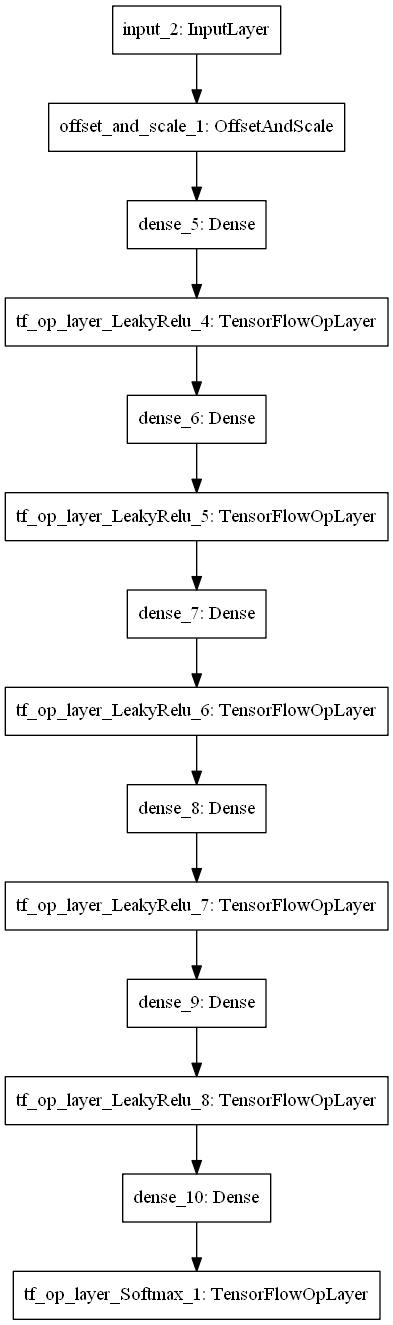

In [17]:
keras.utils.plot_model(model)

In [18]:
compile_args = {
    'optimizer': Adam(learning_rate=args.learning_rate, amsgrad=True),
    'loss': 'categorical_crossentropy'
}

model.compile(**compile_args)

fit_args = {
    'batch_size': args.batch_size,
    'epochs': args.epochs,
    'callbacks': [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=args.patience, verbose=1, mode='auto'),
        tf.keras.callbacks.ModelCheckpoint(args.model_output+'.h5', save_best_only=True, verbose=2)
    ],
    'verbose': 1,
    'validation_split': 0.1
}

In [19]:
history = model.fit(data_x, data_y, **fit_args)

Epoch 1/20
179986/180000 [============================>.] - ETA: 0s - loss: 0.4770
Epoch 00001: val_loss improved from inf to 0.46555, saving model to output/tf_model.h5
180000/180000 [==============================] - 149s 828us/step - loss: 0.4770 - val_loss: 0.4656
Epoch 2/20
179952/180000 [============================>.] - ETA: 0s - loss: 0.4619
Epoch 00002: val_loss improved from 0.46555 to 0.45976, saving model to output/tf_model.h5
180000/180000 [==============================] - 150s 833us/step - loss: 0.4619 - val_loss: 0.4598
Epoch 3/20
179941/180000 [============================>.] - ETA: 0s - loss: 0.4595
Epoch 00003: val_loss improved from 0.45976 to 0.45708, saving model to output/tf_model.h5
180000/180000 [==============================] - 150s 832us/step - loss: 0.4595 - val_loss: 0.4571
Epoch 4/20
179953/180000 [============================>.] - ETA: 0s - loss: 0.4581
Epoch 00004: val_loss did not improve from 0.45708
180000/180000 [==============================] - 14

KeyboardInterrupt: 

In [20]:
logging.info(f'Loading data from data/test.h5')

with h5.File('data/test.h5', 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]
    #data_x = data['input'][:5000]
    #data_y = data['target'][:5000]

In [21]:
pred = model.predict(data_x)

In [22]:
def _do_number(data_x, data_y, pred, thrs):

    outdata = np.zeros(
        (pred.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4'),
            ('Output_number_estimated', 'i4'),
            ('NN_layer', 'i4'),
            ('NN_barrelEC', 'i4'),
            ('globalEta', 'f4'),
            ('globalPhi', 'f4'),
            ('cluster_size', 'i4'),
            ('cluster_size_X', 'i4'),
            ('cluster_size_Y', 'i4'),
        ]
    )

    outdata['Output_number'] = pred / np.sum(pred, axis=1, keepdims=True)
    outdata['Output_number_true'] = 1 * data_y[:,0] + \
                                    2 * data_y[:,1] + \
                                    3 * data_y[:,2]

    outdata['Output_number_estimated'][
        np.where(np.logical_and(pred[:,1] < thrs[0], pred[:,2] < thrs[1]))
    ] = 1
    outdata['Output_number_estimated'][
        np.where(np.logical_and(pred[:,1] >= thrs[0], pred[:,2] < thrs[1]))
    ] = 2
    outdata['Output_number_estimated'][
        np.where(pred[:,2] >= thrs[1])
    ] = 3

    auxfields = [
        'NN_layer',
        'NN_barrelEC',
        'globalEta',
        'globalPhi',
        'cluster_size',
        'cluster_size_X',
        'cluster_size_Y'
    ]

    outdata['NN_layer'] = data_x[:, 56]
    outdata['NN_barrelEC'] = data_x[:, 57]
    #for field in auxfields:
    #    outdata[field] = data_x[field]

    return outdata

In [23]:
outdata = _do_number(data_x, data_y, pred, [0.6, 0.2])

In [24]:
with h5.File('{}/{}.h5'.format('output', 'trained_tf_model_apply'), 'w') as hfile:
    for key in outdata.dtype.names:
        hfile.create_dataset(
            key,
            data=outdata[key],
            compression='gzip'
        )

In [25]:
import math
from sklearn.metrics import roc_curve, auc

In [26]:
def doNumber(data_EC, data_Layer, data_number, data_true):

    data = {}

    outdata = np.zeros(
        (data_number.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4')
        ]
    )

    IBL = np.logical_and(data_Layer == 0, data_EC == 0)
    Barrel = np.logical_and(data_Layer > 0, data_EC == 0)
    Endcap = data_EC != 0

    outdata['Output_number'] = data_number
    outdata['Output_number_true'] = data_true

    data['IBL'] = outdata[IBL]
    data['Barrel'] = outdata[Barrel]
    data['Endcap'] = outdata[Endcap]
    return data

In [27]:
def rocGraph(data, classes, name):

    fpr = [[0]*(10) for i in range(len(data))]
    tpr = [[0]*(10) for i in range(len(data))]
    auc1 = [[0]*(10) for i in range(len(data))]

    npoints = 200
    base_fpr = np.exp(np.linspace(math.log(0.0005), 0., npoints))
    colors = ["r", "g", "b"]

    pos, neg = classes
    linetypes = ['-', '--', ':']

    for j, layer in enumerate(data):

        for i, data_split in enumerate(data[layer]):
            
            pos_sel = data_split['Output_number_true'] == pos
            neg_sel = data_split['Output_number_true'] == neg

            isel = np.where(
                np.logical_or(
                    pos_sel,
                    neg_sel,
                )
            )[0]

            fpr[j][i], tpr[j][i], _ = roc_curve(
                data_split['Output_number_true'][isel],
                data_split['Output_number'][isel][:, pos - 1],
                pos_label=pos
            )
            auc1[j][i] = auc(fpr[j][i], tpr[j][i])
        
    for i, layer in enumerate(data):
        
        tpr_array = np.array([])

        for j in range(10):
            tpr_interpolated = np.interp(base_fpr, fpr[i][j], tpr[i][j])
            tpr_interpolated = tpr_interpolated.reshape((1,npoints))
            tpr_array = np.concatenate([tpr_array, tpr_interpolated], axis=0) if tpr_array.size else tpr_interpolated
            
        mean_tpr = np.mean(tpr_array, axis=0)
        rms_tpr = np.std(tpr_array, axis=0)
        plus_tpr = np.minimum(mean_tpr+rms_tpr, np.ones(npoints))
        minus_tpr = np.maximum(mean_tpr-rms_tpr,np.zeros(npoints))
        plt.plot(base_fpr, mean_tpr, linetypes[i], label=f'{layer} (AUC = {np.mean(auc1[i]):.2f} (+- {np.std(auc1[i]):.4f}))')
        plt.fill_between(base_fpr, minus_tpr, plus_tpr, alpha=0.3)
        
        
    rand_chance = np.linspace(0, 1, 100)
    plt.plot(rand_chance,rand_chance, ':', color='grey', label='Random (AUC = 0.5)')
    plt.semilogx()
    plt.ylabel(f"Pr(Estimated: {pos}-particle | True: {pos}-particle)")
    plt.xlabel(f"Pr(Estimated: {pos}-particle | True: {neg}-particle)")
    plt.xlim([0.001, 1.05])
    plt.ylim(0,1.05)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.figtext(0.25, 0.90,f'{pos} vs {neg}',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    plt.savefig(f'output/{name}{pos}{neg}_ROC.png')
    plt.close()
    
def doRocs(data, name):
    rocGraph(data, (3, 2), name)
    rocGraph(data, (3, 1), name)
    rocGraph(data, (2, 3), name)
    rocGraph(data, (2, 1), name)
    rocGraph(data, (1, 2), name)
    rocGraph(data, (1, 3), name)

In [28]:
with h5.File(f'output/trained_tf_model_apply.h5', 'r') as data:
    data_EC = data['NN_barrelEC'][()]
    data_Layer = data['NN_layer'][()]
    data_number = data['Output_number'][()]
    data_true = data['Output_number_true'][()]

In [29]:
data = doNumber(data_EC, data_Layer, data_number, data_true)

In [30]:
for i, layer in enumerate(data):
    data[layer] = np.array_split(data[layer], 10)
doRocs(data, 'trained_tf_model')

In [ ]:
pred